In [1]:
import sys, importlib

# Put your project directory at the *front* of sys.path
sys.path.insert(0, r"C:\Users\dyuma\Projects\kerr_infall_raytracer")

# Make sure we don't reuse the site-packages version
if "kerr_cpp" in sys.modules:
    del sys.modules["kerr_cpp"]

import kerr_cpp
print("kerr_cpp from:", kerr_cpp.__file__)
help(kerr_cpp.render_frame_full)

import numpy as np
import matplotlib.pyplot as plt

import kerr_cpp  # your compiled extension

%matplotlib inline

kerr_cpp from: C:\Users\dyuma\Projects\kerr_infall_raytracer\kerr_cpp.cp313-win_amd64.pyd
Help on built-in function render_frame_full in module kerr_cpp:

render_frame_full(...) method of pybind11_builtins.pybind11_detail_function_record_v1_msvc_md_mscver19 instance
    render_frame_full(x_obs: typing.Annotated[numpy.typing.ArrayLike, numpy.float64], u_obs: typing.Annotated[numpy.typing.ArrayLike, numpy.float64], width: typing.SupportsInt | typing.SupportsIndex, height: typing.SupportsInt | typing.SupportsIndex, fov_deg: typing.SupportsFloat | typing.SupportsIndex, M: typing.SupportsFloat | typing.SupportsIndex, a: typing.SupportsFloat | typing.SupportsIndex, dl: typing.SupportsFloat | typing.SupportsIndex, max_steps: typing.SupportsInt | typing.SupportsIndex, r_escape: typing.SupportsFloat | typing.SupportsIndex, sky_texture: typing.Annotated[numpy.typing.ArrayLike, numpy.float64]) -> numpy.typing.NDArray[numpy.float64]



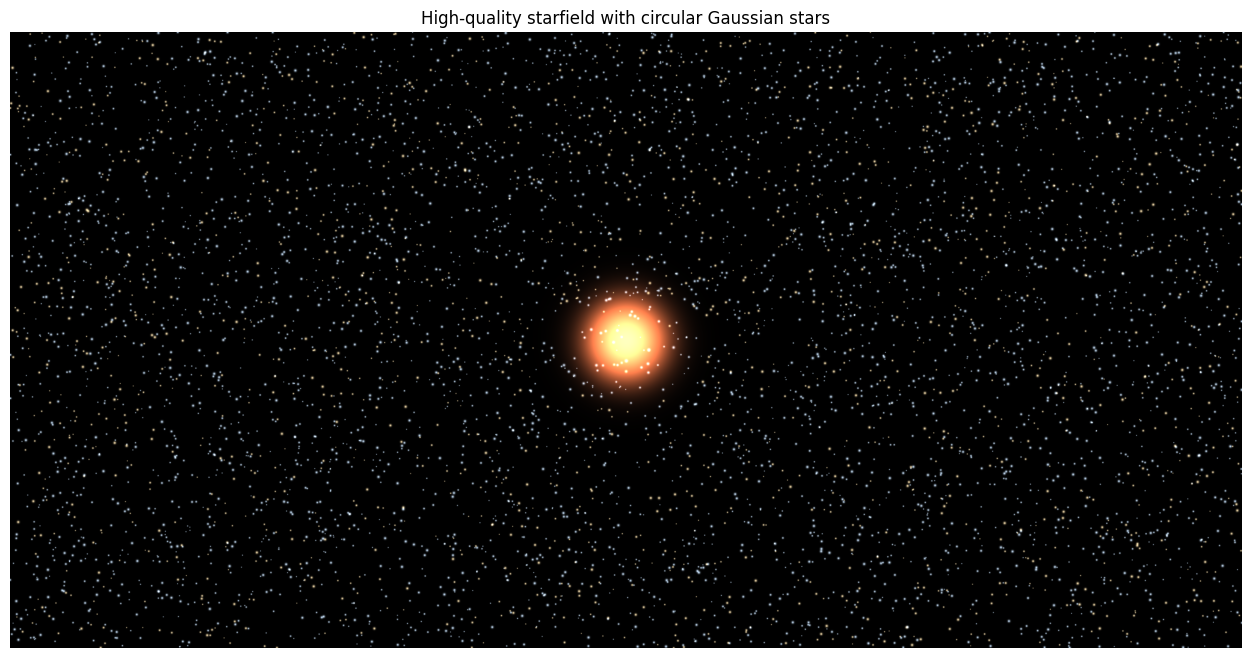

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def make_starfield_smooth(
    height=1024,
    width=2048,
    n_stars=5000,
    big_star=False,
    seed=0
):
    """
    Produce a high-quality starfield with circular stars (Gaussian PSF),
    suitable for gravitational lensing visualization. No pixel squares.
    """
    rng = np.random.default_rng(seed)
    img = np.zeros((height, width, 3), dtype=np.float64)

    # Background darkness
    img += 0.002

    # ------------------------------------------------------------
    # Small stars
    # ------------------------------------------------------------
    ys = rng.uniform(0, height, size=n_stars)
    xs = rng.uniform(0, width,  size=n_stars)

    # Gaussian widths (random star sizes)
    sigmas = rng.uniform(0.5, 1.5, size=n_stars)

    for x0, y0, s in zip(xs, ys, sigmas):
        # Random color temperature-ish variation
        if rng.random() < 0.7:
            color = np.array([0.8, 0.9, 1.0])  # blueish-white
        else:
            color = np.array([1.0, 0.9, 0.7])  # warm

        # A tiny 5×5 sampling window around star center
        ix0 = int(x0)
        iy0 = int(y0)

        for dx in range(-4, 5):
            for dy in range(-4, 5):
                xx = ix0 + dx
                yy = iy0 + dy
                if 0 <= xx < width and 0 <= yy < height:
                    # True subpixel Gaussian
                    r2 = ((xx + 0.5 - x0)**2 + (yy + 0.5 - y0)**2)
                    val = np.exp(-r2 / (2 * s * s))
                    img[yy, xx, :] += val * color

    # ------------------------------------------------------------
    # One big red giant (optional)
    # ------------------------------------------------------------
    if big_star:
        # place it near equator, mid longitudes
        cy = height * 0.5
        cx = width  * 0.5
        R  = height * 0.04

        color_big = np.array([1.0, 0.5, 0.3])

        y = np.arange(height)[:, None]
        x = np.arange(width)[None, :]
        r2 = (x - cx)**2 + (y - cy)**2
        g  = np.exp(-r2 / (2 * R**2))

        img += 2.5 * g[...,None] * color_big

    # Normalize
    img = np.clip(img, 0.0, 1.0)
    return img


# Create the high-quality starfield
sky_tex = make_starfield_smooth(
    height=1024,
    width=2048,
    n_stars=6000,
    big_star=True,     # turn on the red giant
    seed=0
)

plt.figure(figsize=(16,8))
plt.imshow(sky_tex)
plt.axis("off")
plt.title("High-quality starfield with circular Gaussian stars")
plt.show()


In [3]:
# Black hole parameters
M = 1.0
a = 0.9  # spin parameter

# Start the camera far away on equatorial plane, φ = 0
r_start = 100.0
x0 = np.array([0.0, r_start, np.pi / 2, 0.0], dtype=np.float64)  # (v, r, θ, φ)

# Initial 4-velocity guess; C++ will renormalise to timelike
u0 = np.array([1.0, 0.0, 0.0, 0.0], dtype=np.float64)

# Proper-time step and stopping radius
d_tau = 0.5
r_min = 8.0          # stop when r <= r_min
max_steps_geo = 2000

tau, X_traj, U_traj = kerr_cpp.integrate_timelike_to_rmin(
    x0, u0, M, a, d_tau, r_min, max_steps_geo
)

X_traj = np.asarray(X_traj)
U_traj = np.asarray(U_traj)

print("Number of timelike steps:", X_traj.shape[0])
print("Final radius r:", X_traj[-1, 1])

# Use the last point as the camera state
x_obs = X_traj[-1].copy()
u_obs = U_traj[-1].copy()

x_obs, u_obs


Number of timelike steps: 2001
Final radius r: 35.0528506055119


(array([ 9.49855712e+02,  3.50528506e+01,  1.57079633e+00, -1.50840030e-02]),
 array([ 8.45639152e-01, -1.92565906e-01,  1.58563804e-22, -1.20423398e-04]))

Image min/max: 0.0 1.0


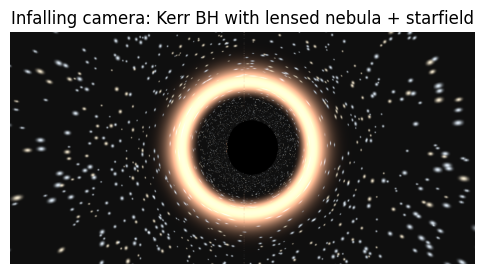

In [4]:
# Image resolution and optical parameters
width  = 1024
height = 512
fov_deg = 100.0

# Null geodesic integration params
dl = 0.01
max_steps = 20000
r_escape = 200.0

# Make sure the sky texture is float64 and C-contiguous
sky_tex_np = np.ascontiguousarray(sky_tex.astype(np.float64))

img = kerr_cpp.render_frame_full(
    x_obs, u_obs,
    width, height,
    fov_deg,
    M, a,
    dl,
    max_steps,
    r_escape,
    sky_tex_np
)

img = np.asarray(img)  # (H, W, 3)

print("Image min/max:", img.min(), img.max())

plt.figure(figsize=(6, 6))
plt.imshow(np.clip(img, 0.0, 1.0))
plt.axis("off")
plt.title("Infalling camera: Kerr BH with lensed nebula + starfield")
plt.show()


Initial u0 (EF coords): [ 1.01531835e+00 -1.22070313e-08  0.00000000e+00  1.01440540e-03]
Timelike steps: 600001
r range: 99.99998763373077 → 100.00001236576401
Total Δφ ≈ 0.9686858053845256 orbits
Using 200 frames
Rendering progress: 1/200 frames (  0.5%)
Rendering progress: 2/200 frames (  1.0%)
Rendering progress: 3/200 frames (  1.5%)
Rendering progress: 4/200 frames (  2.0%)
Rendering progress: 5/200 frames (  2.5%)
Rendering progress: 6/200 frames (  3.0%)
Rendering progress: 7/200 frames (  3.5%)
Rendering progress: 8/200 frames (  4.0%)
Rendering progress: 9/200 frames (  4.5%)
Rendering progress: 10/200 frames (  5.0%)
Rendering progress: 11/200 frames (  5.5%)
Rendering progress: 12/200 frames (  6.0%)
Rendering progress: 13/200 frames (  6.5%)
Rendering progress: 14/200 frames (  7.0%)
Rendering progress: 15/200 frames (  7.5%)
Rendering progress: 16/200 frames (  8.0%)
Rendering progress: 17/200 frames (  8.5%)
Rendering progress: 18/200 frames (  9.0%)
Rendering progress: 

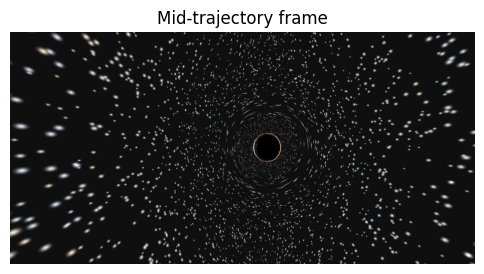

Saved GIF and MP4 for E=0.995, Lz=10.127


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import kerr_cpp

# ============================================================
# Kerr helpers: equatorial geodesic ICs in EF coords
# ============================================================

def kerr_equatorial_u_EF(r, M, a, E, Lz, inward=True):
    """
    Given (r, M, a, E, Lz) for an equatorial (θ=π/2) Kerr geodesic with Q=0,
    return u^μ in ingoing Kerr coordinates (v, r, θ, φ~).
    We choose the sign of dr/dτ via 'inward'.
    """
    Sigma = r**2
    Delta = r**2 - 2.0*M*r + a*a

    A = E*(r*r + a*a) - a*Lz
    R = A*A - Delta*((Lz - a*E)**2 + r*r)

    if R < 0:
        raise RuntimeError(f"R(r0) < 0 for r={r}, E={E}, Lz={Lz} → no real dr/dτ")

    # radial component in BL coords
    ur_BL = -np.sqrt(R)/Sigma if inward else np.sqrt(R)/Sigma

    # dt/dτ in BL
    ut_BL = ((r*r + a*a)*A + a*(Lz - a*E)*Delta) / (Delta * Sigma)

    # dφ/dτ in BL
    uphi_BL = (a*A + (Lz - a*E)*Delta) / (Delta * Sigma)

    # Transform BL → ingoing EF (v, r, θ, φ~)
    # dv = dt + (r^2 + a^2)/Δ dr,  dφ~ = dφ + a/Δ dr
    uv = ut_BL + (r*r + a*a)/Delta * ur_BL
    ur = ur_BL
    uth = 0.0
    uphi_tilde = uphi_BL + a/Delta * ur_BL

    return np.array([uv, ur, uth, uphi_tilde], dtype=np.float64)


def horizon_radius(M, a):
    disc = M*M - a*a
    if disc < 0.0:
        disc = 0.0
    return M + np.sqrt(disc)


# ============================================================
# 1. Choose constants and initial conditions
# ============================================================

M = 1.0
a = 0.9

# Choose initial Boyer–Lindquist radius and constants of motion
r_start = 100.0

import numpy as np

def kerr_circular_E_Lz(r0, M=1.0, a=0.0, prograde=True):
    """
    Specific energy E and angular momentum L_z for an equatorial
    circular geodesic at radius r0 around a Kerr BH (M,a).

    r0, M, a in geometric units (G=c=1). Requires r0 outside the ISCO.

    prograde=True  → co-rotating orbit (same sense as +a)
    prograde=False → counter-rotating orbit
    """
    r0 = float(r0)
    M  = float(M)
    a  = float(a)

    s = +1.0 if prograde else -1.0  # +1: prograde, -1: retrograde

    sqrtM  = np.sqrt(M)
    sqrt_r = np.sqrt(r0)

    denom_inner = r0**1.5 - 3.0*M*sqrt_r + 2.0*s*a*sqrtM
    if denom_inner <= 0.0:
        raise ValueError(
            f"r0={r0} is too small (inside ISCO/unstable region) "
            f"for M={M}, a={a}, prograde={prograde}"
        )

    denom = r0**0.75 * np.sqrt(denom_inner)

    # Energy
    num_E = r0**1.5 - 2.0*M*sqrt_r + s*a*sqrtM
    E = num_E / denom

    # Angular momentum
    num_L = s * sqrtM * (r0**2 - 2.0*s*a*sqrtM*sqrt_r + a**2)
    Lz = num_L / denom

    return E, Lz

E, Lz = kerr_circular_E_Lz(r0=100.0, M=1.0, a=0.9, prograde=True)

# EF coordinates at start: v=0, θ=π/2, φ~=0 (φ0, v0 shifts don't matter)
x0 = np.array([0.0, r_start, np.pi/2, 0.0], dtype=np.float64)

# EF 4-velocity from analytic Kerr formulas
u0 = kerr_equatorial_u_EF(r_start, M, a, E, Lz, inward=True)

# Let the C++ side renormalize exactly with its EF metric
print("Initial u0 (EF coords):", u0)

# ============================================================
# 2. Integrate timelike geodesic with small proper-time steps
# ============================================================

d_tau = 0.01                    # small proper time step
r_plus = horizon_radius(M, a)
r_min  = 0.8 * r_plus           # stop near the horizon
max_steps_geo = 600000

tau_total, X_traj, U_traj = kerr_cpp.integrate_timelike_to_rmin(
    x0, u0, M, a, d_tau, r_min, max_steps_geo
)

X_traj = np.asarray(X_traj)
U_traj = np.asarray(U_traj)

print("Timelike steps:", X_traj.shape[0])
print("r range:", X_traj[:,1].min(), "→", X_traj[:,1].max())

phi = np.unwrap(X_traj[:,3])
delta_phi = phi[-1] - phi[0]
print("Total Δφ ≈", delta_phi/(2*np.pi), "orbits")

# ============================================================
# 3. Choose frames along the trajectory
# ============================================================

n_frames = 200
n_steps  = X_traj.shape[0]
if n_steps < n_frames:
    n_frames = n_steps

frame_idxs = np.linspace(0, n_steps - 1, num=n_frames, dtype=int)
print("Using", n_frames, "frames")

# ============================================================
# 4. Render each frame along the orbit
# ============================================================

width   = 1024
height  = 512
fov_deg = 80.0

dl             = 0.01
max_steps_null = 60000
r_escape       = 200.0

# sky_tex: your (H,W,3) background
sky_tex_np = np.ascontiguousarray(sky_tex.astype(np.float64))

frames = []

import os

output_dir = "orbit_frames"
os.makedirs(output_dir, exist_ok=True)

for k, idx in enumerate(frame_idxs):
    x_obs = X_traj[idx]
    u_obs = U_traj[idx]

    img = kerr_cpp.render_frame_full(
        x_obs, u_obs,
        width, height,
        fov_deg,
        M, a,
        dl,
        max_steps_null,
        r_escape,
        sky_tex_np
    )
    img = np.clip(np.asarray(img), 0.0, 1.0)
    frames.append(img)

    # Save individual frame into folder
    frame_path = os.path.join(output_dir, f"frame_{k:04d}.png")
    plt.imsave(frame_path, img)

    if (k + 1) % 1 == 0 or k == 0 or k == n_frames - 1:
        pct = 100.0 * (k + 1) / n_frames
        print(f"Rendering progress: {k+1}/{n_frames} frames ({pct:5.1f}%)")

# Quick sanity preview
plt.figure(figsize=(6,6))
plt.imshow(frames[len(frames)//2])
plt.axis("off")
plt.title("Mid-trajectory frame")
plt.show()

# ============================================================
# 5. Save movie
# ============================================================

frames_u8 = [(f * 255).astype(np.uint8) for f in frames]

imageio.mimsave("kerr_orbit_E1_Lz{:.2f}.gif".format(Lz), frames_u8, fps=24)
imageio.mimsave("kerr_orbit_E1_Lz{:.2f}.mp4".format(Lz), frames_u8, fps=24)

print("Saved GIF and MP4 for E=%.3f, Lz=%.3f" % (E, Lz))
